#### Assignment2
1. Name: Hongyang Zhang
2. uid: 770510439
3. title: Assignment2

## DataPreprocessing


In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import keras_tuner as kt
import tensorflow as tf

In [2]:
stroke_pd = pd.read_csv(r"C:\Users\zhang\Downloads\healthcare-dataset-stroke-data-1.csv")
stroke_pd.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,Male,67.0,0,1.0,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,1,51676,Female,61.0,0,0.0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,2,31112,Male,80.0,0,1.0,Yes,Private,Rural,105.92,32.5,never smoked,1
3,3,60182,Female,49.0,0,0.0,Yes,Private,Urban,171.23,34.4,smokes,1
4,4,1665,Female,79.0,1,0.0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<Axes: xlabel='age_cat'>

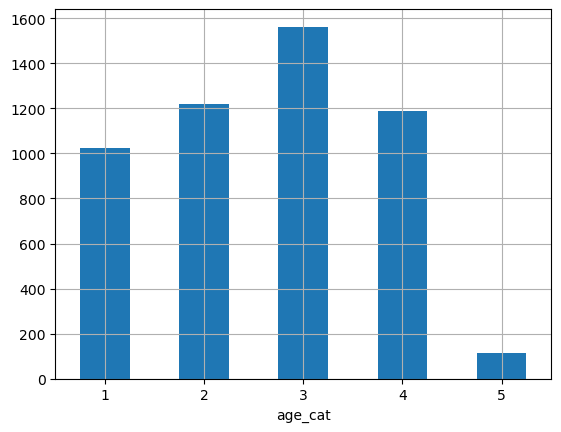

In [3]:
stroke_pd["age_cat"] = pd.cut(stroke_pd["age"],
                               bins=[0., 20, 40, 60, 80, np.inf],
                               labels=[1, 2, 3, 4, 5])
stroke_pd["age_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [4]:
# corr_matrix = stroke_pd.corr(numeric_only=True) #Need to set numeric_only to True with Pandas 2.0
# corr_matrix["stroke"].sort_values(ascending=False)

### set test set

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# stroke_pd_train_set.describe()


In [7]:
# stroke_pd_val_set.describe()

In [8]:
X = stroke_pd.drop('stroke', axis=1)
y = stroke_pd['stroke'].copy()

In [9]:
from sklearn.model_selection import train_test_split

X_train_total, X_test, y_train_total, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_total, y_train_total, test_size=0.25, stratify=y_train_total, random_state=42)


#### remove outliers

In [10]:
# from sklearn.ensemble import IsolationForest
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")
# stroke_pd_num = X_train.select_dtypes(include=[np.number])
# imputer.fit(stroke_pd_num)
# X = imputer.transform(stroke_pd_num)

# isolation_forest = IsolationForest(random_state=42)
# outlier_pred = isolation_forest.fit_predict(X)
# outliers = X_train.iloc[outlier_pred == -1]

# stroke_pd_no = X_train.iloc[outlier_pred == 1]
# y_train_no_outlier = y_train.iloc[outlier_pred == 1]




In [11]:
print("X_train shape:", X_train.shape)  # Replace X_train with your actual input data variable
print("Y_train shape:", y_train.shape)
print("xval shape:", X_val.shape)  # Replace X_train with your actual input data variable
print("yval shape:", y_val.shape)


X_train shape: (3066, 13)
Y_train shape: (3066,)
xval shape: (1022, 13)
yval shape: (1022,)


### Data pre-processing

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer

def ratio_name(function_transformer, feature_names_in):
    return feature_names_in  # feature names out
    
categories = {
    'gender': ['Female', 'Male', 'Other'],
    'ever_married': ['No', 'Yes'],
    'work_type': ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
    'Residence_type': ['Rural', 'Urban'],
    'smoking_status': ['Unknown', 'formerly smoked', 'never smoked', 'smokes']
}
encoder = OneHotEncoder(categories=[categories['gender'], categories['ever_married'], categories['work_type'],
                                    categories['Residence_type'], categories['smoking_status']],
                        handle_unknown='ignore')


bool_transformer = FunctionTransformer(np.vectorize(lambda x: 1 if x == "Yes" else 0))

bol_pip = make_pipeline(
    FunctionTransformer(np.vectorize(lambda x: 1 if x == "Yes"  else 0), feature_names_out=ratio_name ),
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    encoder)

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
bol_pip_num = make_pipeline(SimpleImputer(strategy="median"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("married", bol_pip, ["ever_married"]),
        ("log", log_pipeline, ["avg_glucose_level"]),
        ("age", default_num_pipeline, ["age"]),
        ("bol", bol_pip_num, ["hypertension","heart_disease"]),
        ("cat",cat_pipeline,  make_column_selector(dtype_include=object)),
    
    ],
        remainder=default_num_pipeline)
X_process_val = preprocessing.fit_transform(X_val)
print(preprocessing.get_feature_names_out())

X_process_train = preprocessing.fit_transform(X_train)


['married__ever_married' 'log__avg_glucose_level' 'age__age'
 'bol__hypertension' 'bol__heart_disease' 'cat__gender_Female'
 'cat__gender_Male' 'cat__gender_Other' 'cat__ever_married_No'
 'cat__ever_married_Yes' 'cat__work_type_Govt_job'
 'cat__work_type_Never_worked' 'cat__work_type_Private'
 'cat__work_type_Self-employed' 'cat__work_type_children'
 'cat__Residence_type_Rural' 'cat__Residence_type_Urban'
 'cat__smoking_status_Unknown' 'cat__smoking_status_formerly smoked'
 'cat__smoking_status_never smoked' 'cat__smoking_status_smokes'
 'remainder__Unnamed: 0' 'remainder__id' 'remainder__bmi'
 'remainder__age_cat']


In [13]:
# print("X_train shape:", X_process_train.shape)  # Replace X_train with your actual input data variable
# print("Y_train shape:", y_train.shape)
# print("x_pretrain_val shape:", X_process_val.shape)
# print("Y_val", y_val.shape)

# print(len(preprocessing.get_feature_names_out()))


In [14]:
pre_stroke = pd.DataFrame(X_process_train, columns=preprocessing.get_feature_names_out())
pre_stroke_val = pd.DataFrame(X_process_val, columns=preprocessing.get_feature_names_out())

# pre_storke["stroke"] = y_train_no_outlier
# pre_storke.hist(bins=50, figsize=(12, 16))
# plt.tight_layout()
# plt.show()

In [15]:
# corr_matrix = pre_storke.corr(numeric_only=True)
# corr_matrix["stroke"].sort_values(ascending=False)


In [16]:
# print("X_train shape:", pre_stroke.shape)  # Replace X_train with your actual input data variable
# print("Y_train shape:", y_train.shape)
# print("x_pretrain_val shape:", pre_stroke_val.shape)
# print("y_pretrain_val shape:", y_val.shape)


In [17]:
pre_stroke["stroke"] = y_train
# pre_storke.hist(bins=50, figsize=(12, 16))


In [18]:
# pre_stroke.head()


In [19]:
# print(pre_stroke.shape)

In [20]:

# corr_matrix = pre_stroke.corr(numeric_only=True) #Need to set numeric_only to True with Pandas 2.0
# corr_matrix["stroke"].sort_values(ascending=False)


In [21]:
def drop_unrelated(dataset):
    columns_to_drop = [
    "age__age",
    "remainder__bmi",
    "cat__Residence_type_Rural",
    "cat__ever_married_No",
    "married__ever_married",
    "cat__ever_married_Yes",
    "cat__work_type_Self-employed"
]
    after = dataset.drop(columns_to_drop, axis=1)
    return after

pre_stroke = drop_unrelated(pre_stroke)
pre_stroke_val = drop_unrelated(pre_stroke_val)

In [22]:
pre_stroke = pre_stroke.drop("stroke", axis=1)

In [23]:
print("X_train shape:", pre_stroke.shape)  # Replace X_train with your actual input data variable
print("Y_train shape:", y_train.shape)
print("x_pretrain_val shape:", pre_stroke_val.shape)
print("y_pretrain_val shape:", y_val.shape)

X_train shape: (3066, 18)
Y_train shape: (3066,)
x_pretrain_val shape: (1022, 18)
y_pretrain_val shape: (1022,)


## Dynamic tuning
1. give a range of hidden, layer, neuron, learning rate and optimizer.
2. using step 1 to find the best configuration
3. the reason using sparse_categorical_crossentropy is because we want to classify a person has stroke or not.

In [24]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [25]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=10, overwrite=False,
    directory="a2_minst", project_name="a2", seed=42)



Reloading Tuner from a2_minst\a2\tuner0.json


In [26]:
random_search_tuner.search(pre_stroke, y_train, epochs=10,
                           validation_data=(pre_stroke_val, y_val))

In [27]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [28]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values


{'n_hidden': 7,
 'n_neurons': 124,
 'learning_rate': 0.0005509513888645584,
 'optimizer': 'adam'}

In [29]:
top3_params[1].values


{'n_hidden': 7,
 'n_neurons': 51,
 'learning_rate': 0.0003491260272208854,
 'optimizer': 'adam'}

In [30]:
top3_params[2].values

{'n_hidden': 4,
 'n_neurons': 74,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'adam'}

#### evaluation using validation error and trainng error

In [31]:
val_loss, val_accuracy = best_model.evaluate(pre_stroke_val, y_val)
print("Validation Error (Loss):", val_loss)
print("Validation Accuracy:", val_accuracy)

# Optionally evaluate on training data
train_loss, train_accuracy = best_model.evaluate(pre_stroke, y_train)
print("Training Error (Loss):", train_loss)
print("Training Accuracy:", train_accuracy)

32/32 [==============================] - 0s 954us/step - loss: 0.0444 - accuracy: 0.9863
Validation Error (Loss): 0.044445618987083435
Validation Accuracy: 0.9863013625144958
96/96 [==============================] - 0s 831us/step - loss: 0.0135 - accuracy: 0.9951
Training Error (Loss): 0.013535801321268082
Training Accuracy: 0.9951076507568359


In [32]:
history = best_model.fit(pre_stroke, y_train, epochs=20,
                    validation_data=(pre_stroke_val, y_val))

Epoch 1/20
96/96 [==============================] - 2s 3ms/step - loss: 0.0229 - accuracy: 0.9905 - val_loss: 0.0406 - val_accuracy: 0.9853
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0536 - val_accuracy: 0.9804
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9945 - val_loss: 0.0555 - val_accuracy: 0.9814
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9935 - val_loss: 0.0475 - val_accuracy: 0.9853
Epoch 5/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9912 - val_loss: 0.0485 - val_accuracy: 0.9775
Epoch 6/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9958 - val_loss: 0.0581 - val_accuracy: 0.9834
Epoch 7/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0681 - val_accuracy: 0.9843
Epoch 8/20
96/96 [==

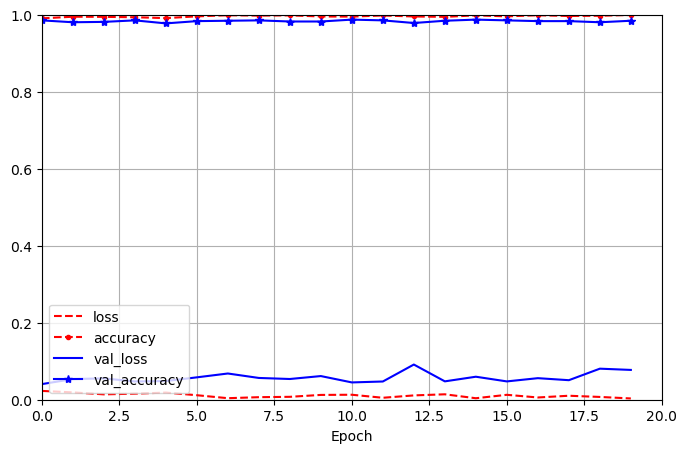

In [33]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

#### According to the diagram, the there is no simbol of overfitting and the accuracy is good so i will try to acclerate the traning time of the model

# Using Fixed Architecture Model

#### according to the dynamic tuning, the layer 4 with neuron 74 will be good

In [34]:
def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(74, activation="relu",
                              kernel_initializer="he_normal", input_shape=[18]),
        tf.keras.layers.Dense(74, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(74, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(74, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

In [35]:
model = build_model() 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(pre_stroke, y_train, epochs=20,
                    validation_data=(pre_stroke_val, y_val))

Epoch 1/20
96/96 [==============================] - 1s 3ms/step - loss: 0.2110 - accuracy: 0.9410 - val_loss: 0.1169 - val_accuracy: 0.9530
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0970 - accuracy: 0.9605 - val_loss: 0.0967 - val_accuracy: 0.9658
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9693 - val_loss: 0.0850 - val_accuracy: 0.9697
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9710 - val_loss: 0.0811 - val_accuracy: 0.9648
Epoch 5/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9752 - val_loss: 0.0737 - val_accuracy: 0.9726
Epoch 6/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0587 - accuracy: 0.9726 - val_loss: 0.0673 - val_accuracy: 0.9726
Epoch 7/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0537 - accuracy: 0.9775 - val_loss: 0.0637 - val_accuracy: 0.9755
Epoch 8/20
96/96 [==

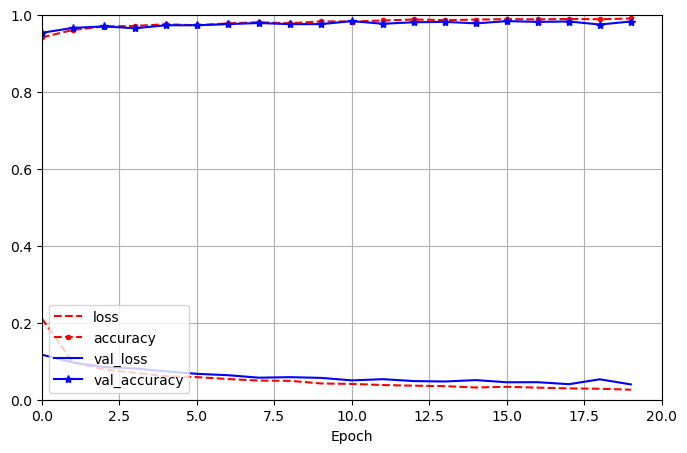

In [36]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

In [37]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [38]:
y_pred = model.predict(pre_stroke_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 808us/step


In [39]:
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[963   9]
 [  9  41]]


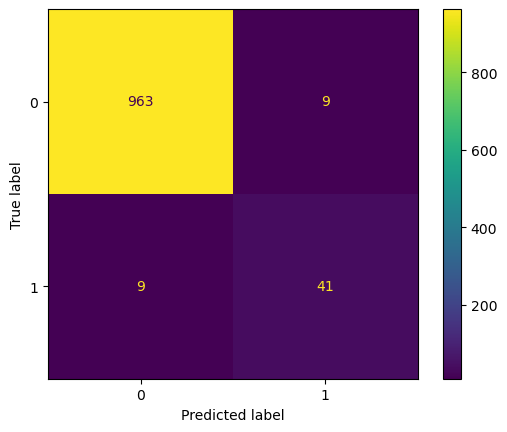

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

recall_score(y_val, y_pred_classes)

0.82

#### Did not see any symbol of overfitting but we can accelerate the process using Adam

##### using Adam

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [43]:
model = build_model() 
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])

Epoch 1/20
96/96 [==============================] - 1s 3ms/step - loss: 0.3425 - accuracy: 0.9211 - val_loss: 0.1001 - val_accuracy: 0.9618
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0824 - accuracy: 0.9654 - val_loss: 0.0967 - val_accuracy: 0.9501
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9697 - val_loss: 0.0638 - val_accuracy: 0.9706
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9752 - val_loss: 0.0715 - val_accuracy: 0.9638
Epoch 5/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.0634 - val_accuracy: 0.9746
Epoch 6/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9886 - val_loss: 0.0575 - val_accuracy: 0.9775
Epoch 7/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9879 - val_loss: 0.0685 - val_accuracy: 0.9658
Epoch 8/20
96/96 [==

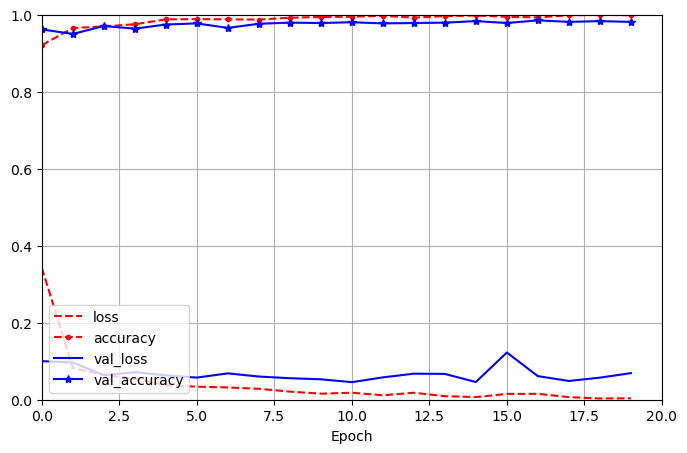

In [44]:
Adam = model.fit(pre_stroke, y_train, epochs=20,
                                           validation_data=(pre_stroke_val, y_val))

pd.DataFrame(Adam.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

#### prevent large weight uisng regularisation

In [45]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model_reg = tf.keras.Sequential([
    RegularizedDense(74, input_shape=[18]),
    RegularizedDense(74),
    RegularizedDense(74),
    RegularizedDense(74),
    RegularizedDense(74),
    RegularizedDense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_reg.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])

history_reg = model_reg.fit(pre_stroke, y_train, epochs=20,
                    validation_data=(pre_stroke_val, y_val))

Epoch 1/20
96/96 [==============================] - 2s 4ms/step - loss: 6.2936 - accuracy: 0.9168 - val_loss: 4.5770 - val_accuracy: 0.9560
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 3.5177 - accuracy: 0.9648 - val_loss: 2.6465 - val_accuracy: 0.9648
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 2.0833 - accuracy: 0.9706 - val_loss: 1.6296 - val_accuracy: 0.9687
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 1.3129 - accuracy: 0.9785 - val_loss: 1.0635 - val_accuracy: 0.9755
Epoch 5/20
96/96 [==============================] - 0s 2ms/step - loss: 0.8925 - accuracy: 0.9759 - val_loss: 0.7473 - val_accuracy: 0.9765
Epoch 6/20
96/96 [==============================] - 0s 2ms/step - loss: 0.6431 - accuracy: 0.9791 - val_loss: 0.5596 - val_accuracy: 0.9843
Epoch 7/20
96/96 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.9791 - val_loss: 0.4471 - val_accuracy: 0.9892
Epoch 8/20
96/96 [==

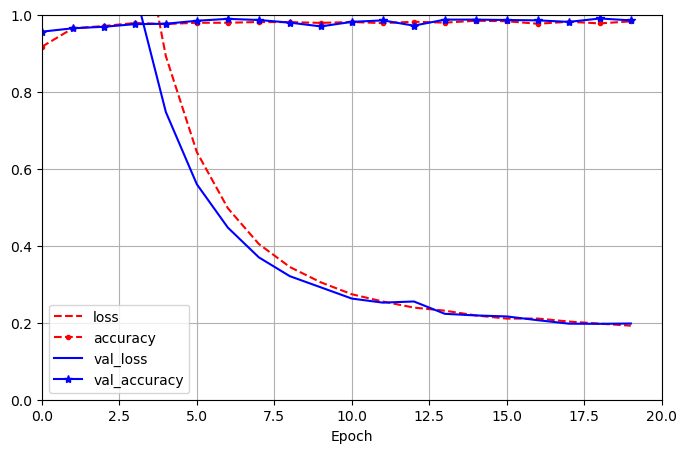

In [46]:
pd.DataFrame(history_reg.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()